- [12.2.2 - Are different groups equal or not?](#12.2.2---Are-different-groups-equal-or-not?)

## Chapter 12 - Bayesian Approaches to Testing a Point ("Null") Hypothesis

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode
from sklearn import preprocessing
from theano.tensor import eq
from matplotlib import gridspec

pd.set_option('display.notebook_repr_html', False)

%config InlineBackend.figure_formats = {'retina',}
%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
# Below function takes an array as input.

def plot_posterior(dist, decimals=3, vert_ref=None, alpha=0.05, point_est='mode', burnin=0, y_labels=False, ax=None):
       
    color = '#87ceeb'
    font_d = {'size':14}
    
    if ax == None:
        ax = plt.gca()
               
    hpd_interval = np.round(pmc.hpd(dist[burnin:], alpha=alpha), decimals=decimals)

    # Histogram, Mode/Mean
    sns.distplot(dist[burnin:], kde=False, color=color, ax=ax)
    plot_height = ax.get_ylim()[1]
    
    if point_est == 'mode':
        p_est_value = mode(np.round(dist[burnin:], decimals=decimals))[0][0]
    else:
        p_est_value = np.round(np.mean(dist[burnin:]), decimals=decimals)
    
    ax.text(p_est_value, plot_height*.9, '{} = {}'.format(point_est, p_est_value),
            horizontalalignment='center', fontdict=font_d, clip_on=False)    

    # HPD interval
    ax.hlines(ax.get_ylim()[1]*0.01, *hpd_interval, linewidth=4)
    for interval_point in hpd_interval:
        ax.text(interval_point, plot_height*0.05, interval_point,
                horizontalalignment='center', fontdict=font_d)
    ax.text(np.mean(hpd_interval), plot_height*0.13, '{}% HPD'.format((1-alpha)*100),
            horizontalalignment='center', fontdict=font_d)

    # Reference line
    if vert_ref is None:
        ax.axvline(p_est_value, color='g', linestyle='dotted')
    else:
        ax.axvline(vert_ref, color='g', linestyle='dotted')

    # Set labels and axis
    if y_labels is False:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)
    [ax.spines[spine].set_visible(False) for spine in ['right', 'top']]
    
    return(ax)

#### Data
Using *R*, I executed lines 18-63 from the script `OneOddGroupModelComp2E.R` to generate the exact same data used in the book. The script can be downloaded from the book's website. After executing the lines, the List object `dataList` in *R* contains five elements:
 1. `nCond`: A scalar value (4) representing the number of conditions (background music types).
 2. `nSubj`: A scalar value (80) representing the number of subjects.
 3. `CondOfSubj`: A vector representing the condition (1, 2, 3 or 4) of a subject during a test.
 4. `nTrlOfSubj`: A vector with the number of trials/words per subject (20 for all subjects).
 5. `nCorrOfSubj`: A vector with number of correct recalls per subject.
 
I exported the last three elements of `dataList` to a csv file using the following command in *R*:   
`write.csv(data.frame(dataList[c(3:5)]), file='background_music.csv', row.names=FALSE)`

In [3]:
df = pd.read_csv('data/background_music.csv')

# Mapping the condition descriptions to the condition codes. Just for illustrative purposes.
bgmusic = {1:'Das Kruschke', 2:'Mozart', 3:'Bach', 4:'Beethoven'}
df['CondText'] = df.CondOfSubj.map(bgmusic)

# Encode the 4 condition codes for easier indexing during model specification
le = preprocessing.LabelEncoder()
cond_idx = le.fit_transform(df.CondOfSubj)
cond_codes = le.classes_
nCond = len(le.classes_)

nSubj = df.index.size

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
CondOfSubj     80 non-null int64
nTrlOfSubj     80 non-null int64
nCorrOfSubj    80 non-null int64
CondText       80 non-null object
dtypes: int64(3), object(1)
memory usage: 2.6+ KB


In [4]:
df.groupby('CondOfSubj').head(3)

    CondOfSubj  nTrlOfSubj  nCorrOfSubj      CondText
0            1          20            8  Das Kruschke
1            1          20            7  Das Kruschke
2            1          20            8  Das Kruschke
20           2          20            9        Mozart
21           2          20           12        Mozart
22           2          20            9        Mozart
40           3          20           11          Bach
41           3          20            6          Bach
42           3          20           11          Bach
60           4          20            6     Beethoven
61           4          20           12     Beethoven
62           4          20           12     Beethoven

### 12.2.2 - Are different groups equal or not?
Given the data, how credible is it that the 4 types of background music influence the ability to recall words 
**differently**?

In [5]:
# The means as mentioned in section 12.2.2
df.groupby('CondText', sort=False)['nCorrOfSubj'].mean()

CondText
Das Kruschke     8.0
Mozart          10.0
Bach            10.2
Beethoven       10.4
Name: nCorrOfSubj, dtype: float64

### Model specification in JAGS
(Kruschke, 2015)

In [ ]:
model {
  for ( s in 1:nSubj ) {
    nCorrOfSubj[s] ~ dbin( theta[s] , nTrlOfSubj[s] )
    theta[s] ~ dbeta( aBeta[CondOfSubj[s]] , bBeta[CondOfSubj[s]] ) 
  }

  for ( j in 1:nCond ) {
    # Use omega[j] for model index 1, omega0 for model index 2:
    aBeta[j] <-       ( equals(mdlIdx,1)*omega[j] 
                      + equals(mdlIdx,2)*omega0  )   * (kappa[j]-2)+1
    bBeta[j] <- ( 1 - ( equals(mdlIdx,1)*omega[j] 
                      + equals(mdlIdx,2)*omega0  ) ) * (kappa[j]-2)+1
    omega[j] ~ dbeta( a[j,mdlIdx] , b[j,mdlIdx] )
  }

  omega0 ~ dbeta( a0[mdlIdx] , b0[mdlIdx] )
  for ( j in 1:nCond ) {
    kappa[j] <- kappaMinusTwo[j] + 2
    kappaMinusTwo[j] ~ dgamma( 2.618 , 0.0809 ) # mode 20 , sd 20
  }
  # Constants for prior and pseudoprior:
  aP <- 1
  bP <- 1
  # a0[model] and b0[model]
  a0[1] <- .48*500       # pseudo
  b0[1] <- (1-.48)*500   # pseudo 
  a0[2] <- aP            # true
  b0[2] <- bP            # true
  # a[condition,model] and b[condition,model]
  a[1,1] <- aP           # true
  a[2,1] <- aP           # true
  a[3,1] <- aP           # true
  a[4,1] <- aP           # true
  b[1,1] <- bP           # true
  b[2,1] <- bP           # true
  b[3,1] <- bP           # true
  b[4,1] <- bP           # true
  a[1,2] <- .40*125      # pseudo
  a[2,2] <- .50*125      # pseudo
  a[3,2] <- .51*125      # pseudo
  b[4,2] <- (1-.52)*125  # pseudo
  # Prior on model index:
  mdlIdx ~ dcat( modelProb[] )
  modelProb[1] <- .5
  modelProb[2] <- .5
}

### PyMC3

Note: in contrast to the *R* output in the book, the parameters in PyMC3 (like $\omega$ and model index) are indexed starting with 0.

In [27]:
with pmc.Model() as model_1:
    # constants
    aP, bP = 1, 1
    
    # Pseudo- and true hyperpriors per model
    a0 = [.48*500, aP]      
    b0 = [(1-.48)*500, bP]  
    
    # Lower level pseudo- and true priors per model/condition combination
    a = np.c_[np.tile(aP, 4), [(.40*125), (.50*125), (.51*125), (.52*125)]]
    b = np.c_[np.tile(bP, 4), [(1-.40*125), (1-.50*125), (1-.51*125), (1-.52*125)]]

In [28]:
print(pd.DataFrame(a, columns=['True priors a', 'Pseudo priors a']))
print(pd.DataFrame(b, columns=['True priors b', 'Pseudo priors b']))

   True priors a  Pseudo priors a
0            1.0            50.00
1            1.0            62.50
2            1.0            63.75
3            1.0            65.00
   True priors b  Pseudo priors b
0            1.0           -49.00
1            1.0           -61.50
2            1.0           -62.75
3            1.0           -64.00


In [40]:
with pmc.Model() as model_1:
    
    # Prior on model index [0,1]
    m_idx = pmc.Categorical('m_idx', np.asarray([.5, .5]))
    
    # Priors on concentration parameters
    kappa = pmc.Gamma('kappa', 2.618, 0.0809, shape=nCond)
        
    # omega0 
    omega0 = pmc.Beta('omega0', a0[m_idx], b0[m_idx])    
        
    # omega (condition specific)
    omega = pmc.Beta('omega0', a[:,m_idx], b[:,m_idx], shape=nCond)
        
    # theta
    aBeta = pmc.switch(eq(m_idx, 0), omega0 * kappa[cond_idx]+1, omega[cond_idx] * kappa[cond_idx]+1)
    bBeta = pmc.switch(eq(m_idx, 0), (1-omega0) * kappa[cond_idx]+1, (1-omega[cond_idx]) * kappa[cond_idx]+1)
        
    theta = pmc.Beta('theta', aBeta[cond_idx], bBeta[cond_idx], shape=df.index.size)
    
    # Likelihood
    y = pmc.Binomial('y', n=df.nTrlOfSubj.values, p=theta, observed=df.nCorrOfSubj)    

Applied log-transform to kappa and added transformed kappa_log_ to model.


TypeError: list indices must be integers or slices, not FreeRV

In [29]:
# Full model
with pmc.Model() as model_1:
    
    omega0 = pmc.Beta('omega0', 1, 1)
    kappa0 = pmc.Gamma('kappa0', 0.01, 0.01)
               
    # omega (condition specific)
    omega = pmc.Beta('omega',
                     omega0 * kappa0+1,
                     (1-omega0) * kappa0+1, shape=nCond)
    
    # Priors on concentration parameters
    kappa = pmc.Gamma('kappa', 0.01, 0.01, shape=nCond)
    
    # theta
    theta = pmc.Beta('theta',
                     omega[cond_idx] * kappa[cond_idx]+1,
                     (1-omega[cond_idx]) * kappa[cond_idx]+1, shape=df.index.size)
    
    # Likelihood
    y = pmc.Binomial('y', n=df.nTrlOfSubj.values, p=theta, observed=df.nCorrOfSubj)    

Applied logodds-transform to omega0 and added transformed omega0_logodds_ to model.
Applied log-transform to kappa0 and added transformed kappa0_log_ to model.
Applied logodds-transform to omega and added transformed omega_logodds_ to model.
Applied log-transform to kappa and added transformed kappa_log_ to model.
Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [30]:
with model_1:
    trace1 = pmc.sample(10000)    

Assigned NUTS to omega0_logodds_
Assigned NUTS to kappa0_log_
Assigned NUTS to omega_logodds_
Assigned NUTS to kappa_log_
Assigned NUTS to theta_logodds_
 [-----------------100%-----------------] 10000 of 10000 complete in 295.6 sec

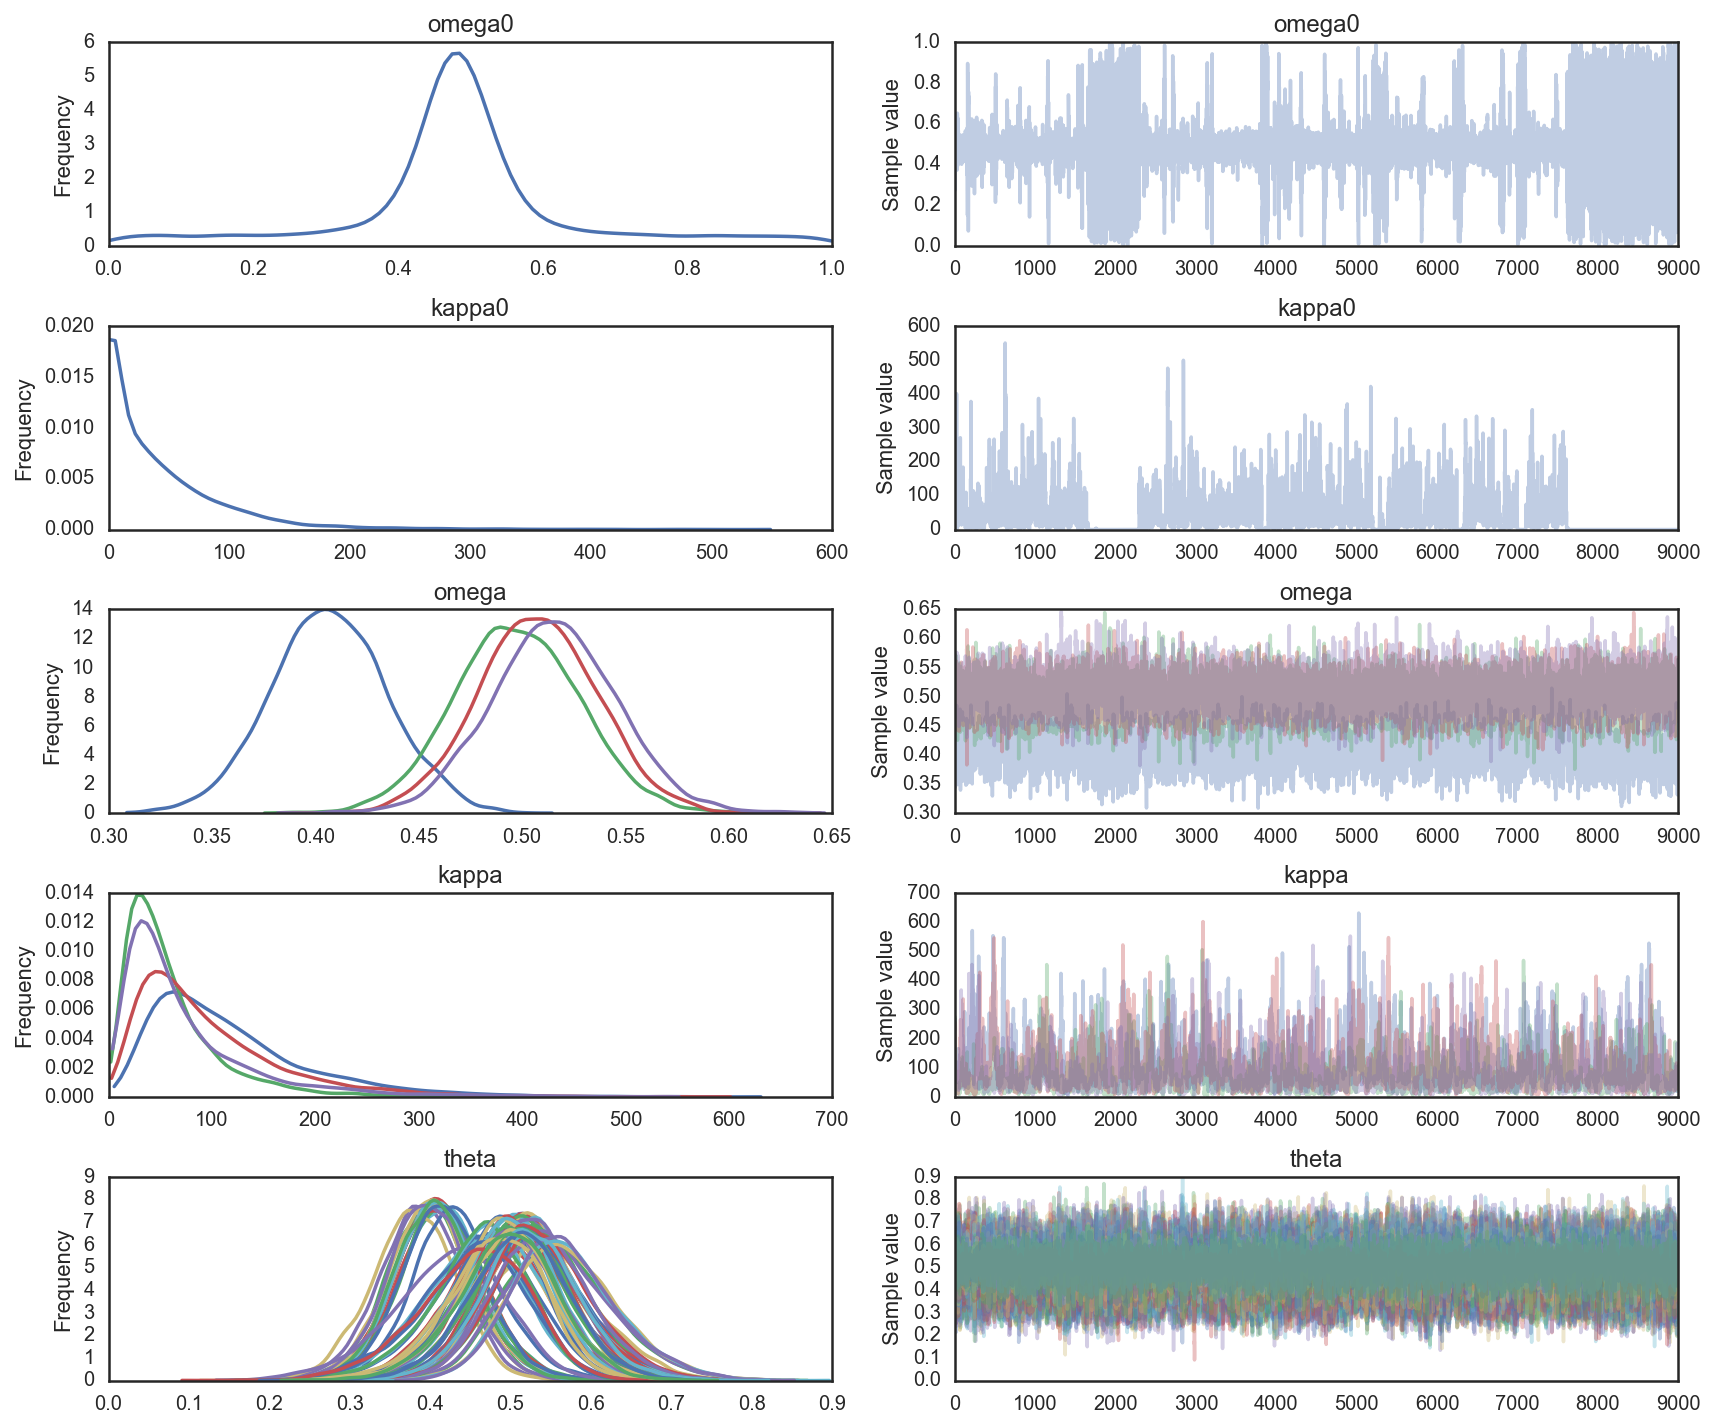

In [36]:
pmc.traceplot(trace1[1000:]);

#### Figure 12.5

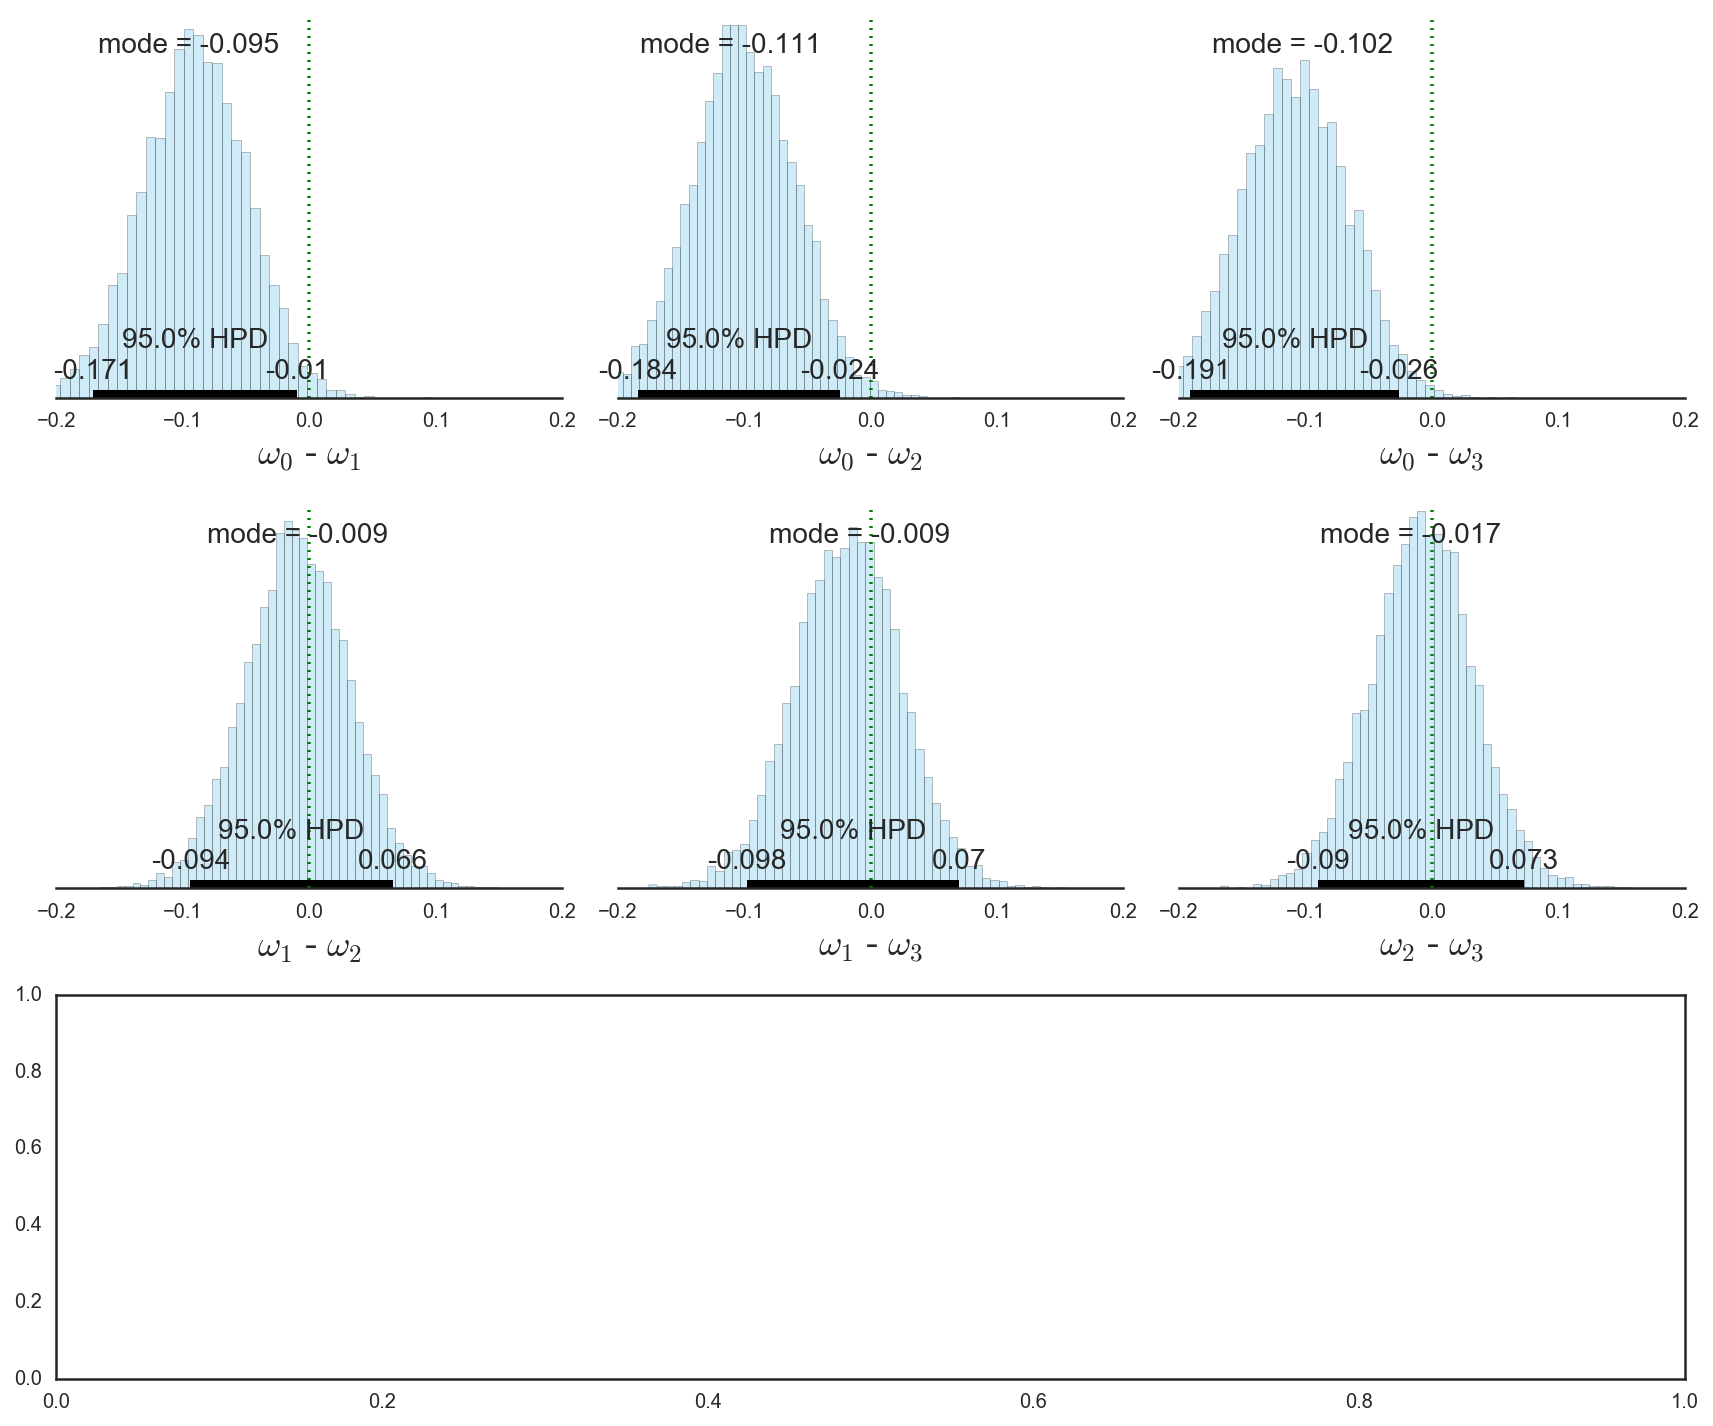

In [37]:
plt.figure(figsize=(12,10))

# Define gridspec
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])
ax7 = plt.subplot(gs[2,:])

# Group the first six axes in a list for easier access in loop below
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
# Differences of posteriors to be displayed: omega x - omega y
x = [0,0,0,1,1,2]
y = [1,2,3,2,3,3]

# Plot histograms
for ax, a, b in zip(axes, x, y):
    diff = trace1['omega'][:,a]-trace1['omega'][:,b]
    plot_posterior(diff, vert_ref=0, burnin=1000, ax=ax)
    
    ax.set_xlabel('$\omega_{}$ - $\omega_{}$'.format(a,b), fontdict={'size':18})
    ax.set_xlim(-0.2,0.2)
    ax.xaxis.set_ticks([-.2, -.1, 0.0, 0.1, 0.2])

# Plot trace values of model index (0, 1)
#ax7.plot(np.arange(1, len(trace1['m_idx'])+1),trace1['m_idx'], color=color, linewidth=4)
#ax7.set_xlabel('Step in Markov chain', fontdict={'size':14})
#ax7.set_ylabel('Model Index (0, 1)', fontdict={'size':14})
#ax7.set_ylim(-0.05,1.05)

plt.tight_layout()